In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 1
!hostname
!pwd

dv002.bridges2.psc.edu
/ocean/projects/asc170022p/mtragoza/mre-pinn/notebooks


In [2]:
import sys, os, pathlib
import numpy as np
import xarray as xr
import torch
import matplotlib.pyplot as plt
import seaborn as sns

os.environ['DDEBACKEND'] = 'pytorch'
import deepxde

sys.path.append('..')
%aimport mre_pinn

torch.cuda.is_available()

Using backend: pytorch



True

In [3]:
%autoreload

cohort = mre_pinn.data.PatientCohort(xarray_dir='../data/NAFLD', patient_ids='0006')
#cohort.create_xarrays()
#cohort.save_xarrays()
#cohort.metadata
cohort.load_xarrays()

  0%|          | 0/1 [00:00<?, ?it/s]Loading ../data/NAFLD/0006/t1_pre_in.nc
Loading ../data/NAFLD/0006/t1_pre_water.nc
Loading ../data/NAFLD/0006/t1_pre_out.nc
Loading ../data/NAFLD/0006/t1_pre_fat.nc
Loading ../data/NAFLD/0006/t2.nc
Loading ../data/NAFLD/0006/mre_raw.nc
Loading ../data/NAFLD/0006/wave.nc
Loading ../data/NAFLD/0006/mre.nc
Loading ../data/NAFLD/0006/mask.nc
100%|██████████| 1/1 [00:00<00:00, 17.54it/s]


In [4]:
pde = mre_pinn.pde.WaveEquation.from_name('helmholtz', detach=True)
pde

In [10]:
%autoreload

pino = mre_pinn.model.pino.SpectralAttention(
    n_spatial_dims=3,
    n_channels_in=4,
    n_channels_out=1,
    n_modes=32,
    n_heads=4
)
pino

SpectralAttention(n_spatial_dims=3, n_channels_in=4, n_channels_out=1, n_modes=32, n_heads=4)

In [11]:
%autoreload

model = mre_pinn.training.PINOModel(cohort, pino, pde, patch_size=128, batch_size=4)
model.compile(
    optimizer='adam',
    lr=1e-3,
    loss_weights=[1e-8, 1e0],
    loss=mre_pinn.training.losses.msae_loss
)   
test_eval = mre_pinn.testing.TestEvaluator(test_every=10, interact=True)

Compiling model...
'compile' took 0.000177 s



Training model...

Step      Train loss              Test loss               Test metric
0         [1.97e-04, 1.97e+04]    [2.84e-05, 2.84e+03]    []  


<IPython.core.display.Javascript object>


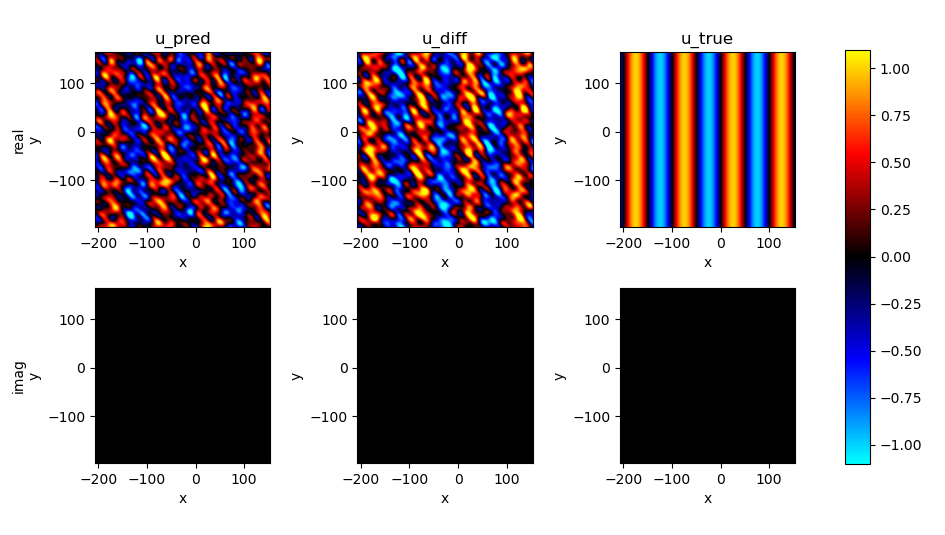

interactive(children=(SelectionSlider(description='domain', options=(('space', 0), ('frequency', 1)), value=0)…

Time spent testing: 11.96%
10        [2.50e-06, 2.50e+02]    [6.13e-07, 6.13e+01]    []  
Time spent testing: 11.05%
20        [1.07e-06, 1.07e+02]    [2.51e-07, 2.51e+01]    []  
Time spent testing: 10.68%
30        [4.89e-07, 4.89e+01]    [1.19e-07, 1.19e+01]    []  
Time spent testing: 10.51%
40        [5.84e-07, 5.84e+01]    [8.34e-08, 8.34e+00]    []  
Time spent testing: 10.41%
50        [3.42e-07, 3.42e+01]    [6.37e-08, 6.37e+00]    []  
Time spent testing: 10.34%
60        [3.05e-07, 3.05e+01]    [6.31e-08, 6.31e+00]    []  
Time spent testing: 10.30%
70        [2.90e-07, 2.90e+01]    [4.80e-08, 4.80e+00]    []  
Time spent testing: 10.26%
80        [1.75e-07, 1.75e+01]    [4.53e-08, 4.53e+00]    []  
Time spent testing: 10.23%
90        [3.01e-07, 3.01e+01]    [3.92e-08, 3.92e+00]    []  
Time spent testing: 10.22%
100       [2.22e-07, 2.22e+01]    [4.40e-08, 4.40e+00]    []  
Time spent testing: 10.21%
110       [1.58e-07, 1.58e+01]    [3.82e-08, 3.82e+00]    []  
Time spent

920       [6.03e-09, 6.03e-01]    [2.91e-09, 2.91e-01]    []  
Time spent testing: 10.27%
930       [7.12e-09, 7.12e-01]    [2.99e-09, 2.99e-01]    []  
Time spent testing: 10.27%
940       [8.24e-09, 8.24e-01]    [2.83e-09, 2.83e-01]    []  
Time spent testing: 10.27%
950       [6.83e-09, 6.83e-01]    [2.81e-09, 2.81e-01]    []  
Time spent testing: 10.28%
960       [7.09e-09, 7.09e-01]    [2.87e-09, 2.87e-01]    []  
Time spent testing: 10.27%
970       [6.67e-09, 6.67e-01]    [2.79e-09, 2.79e-01]    []  
Time spent testing: 10.28%
980       [5.61e-09, 5.61e-01]    [2.68e-09, 2.68e-01]    []  
Time spent testing: 10.28%
990       [6.53e-09, 6.53e-01]    [2.77e-09, 2.77e-01]    []  
Time spent testing: 10.28%
1000      [5.90e-09, 5.90e-01]    [2.82e-09, 2.82e-01]    []  

Best model at step 980:
  train loss: 5.61e-01
  test loss: 2.68e-01
  test metric: []

'train' took 312.189877 s



(<deepxde.model.LossHistory at 0x14b920f27190>,
 <deepxde.model.TrainState at 0x14b924482890>)

In [12]:
model.train(1000, display_every=10, callbacks=[test_eval])